<a href="https://colab.research.google.com/github/SMAntony/deep-learning-tools/blob/main/Lab1_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip"

In [ ]:
path_to_downloaded_file = tf.keras.utils.get_file(
    "dry_beans.zip", 
    dataset_url,
    extract=True,
    cache_dir = ".")


In [ ]:
df = pd.read_excel("/content/datasets/DryBeanDataset/Dry_Bean_Dataset.xlsx")

In [ ]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('Class')
  df = {key: value.values[:,tf.newaxis] for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), pd.get_dummies(labels)))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:

train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])


In [ ]:
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val)
test_ds = df_to_dataset(test)

In [ ]:
val_ds

<PrefetchDataset element_spec=({'Area': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'Perimeter': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'MajorAxisLength': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'MinorAxisLength': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'AspectRation': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Eccentricity': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'ConvexArea': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'EquivDiameter': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Extent': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Solidity': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'roundness': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Compactness': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'ShapeFactor1': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'ShapeFactor2': TensorSpec(sha

In [ ]:
def get_normalization_layer(name, dataset):
  normalizer = tf.keras.layers.Normalization(axis=None)
  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)

  return normalizer

cols = df.drop('Class', axis = 1).columns
cols

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

In [ ]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds) # Normalization
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)


In [ ]:
x = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dense(8, activation="relu")(x)
outputs = tf.keras.layers.Dense(7, activation="softmax")(x)
model = tf.keras.Model(all_inputs,outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)


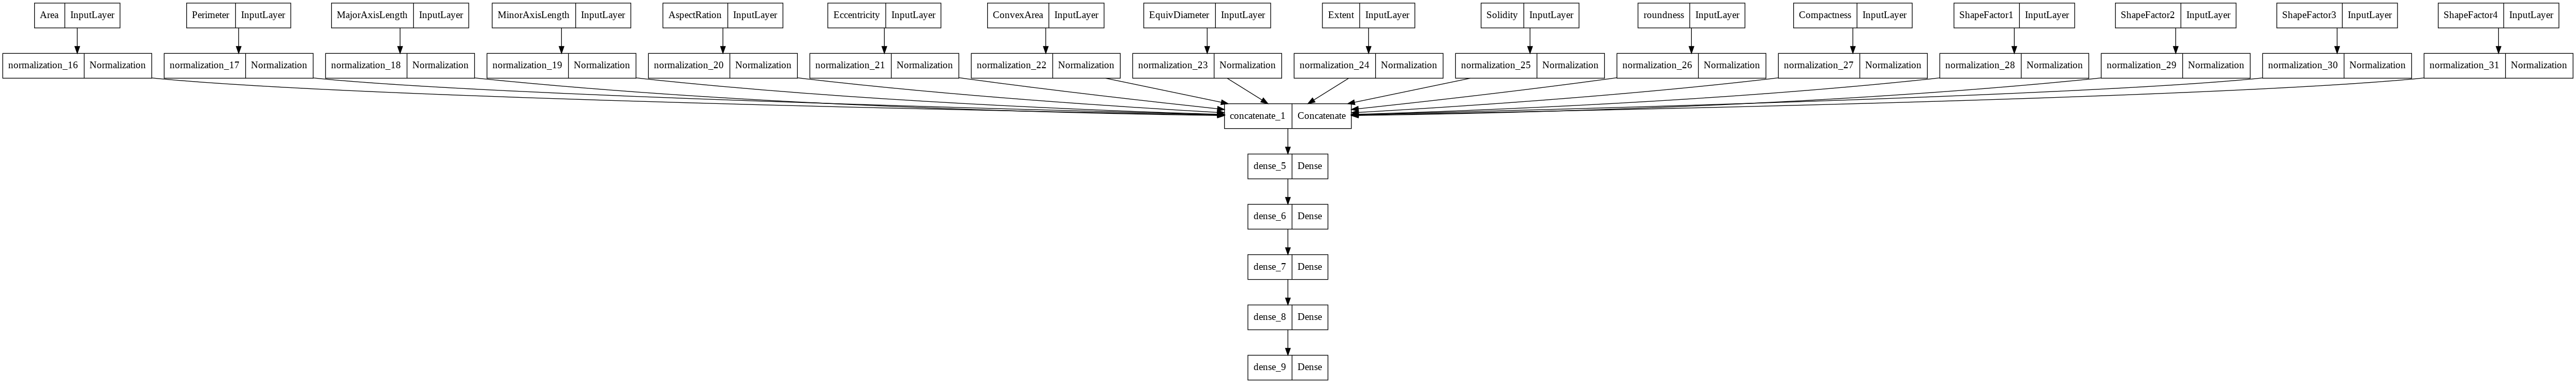

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
  history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/100
341/341 [==============================] - 3s 5ms/step - loss: 0.7709 - accuracy: 0.7341 - val_loss: 0.3228 - val_accuracy: 0.9030
Epoch 2/100
341/341 [==============================] - 2s 4ms/step - loss: 0.2489 - accuracy: 0.9187 - val_loss: 0.2476 - val_accuracy: 0.9162
Epoch 3/100
341/341 [==============================] - 1s 4ms/step - loss: 0.2125 - accuracy: 0.9226 - val_loss: 0.2262 - val_accuracy: 0.9206
Epoch 4/100
341/341 [==============================] - 2s 4ms/step - loss: 0.2042 - accuracy: 0.9247 - val_loss: 0.2199 - val_accuracy: 0.9236
Epoch 5/100
341/341 [==============================] - 2s 4ms/step - loss: 0.1985 - accuracy: 0.9269 - val_loss: 0.2113 - val_accuracy: 0.9258
Epoch 6/100
341/341 [==============================] - 2s 4ms/step - loss: 0.1941 - accuracy: 0.9259 - val_loss: 0.2141 - val_accuracy: 0.9258
Epoch 7/100
341/341 [==============================] - 2s 4ms/step - loss: 0.1912 - accuracy: 0.9291 - val_loss: 0.2133 - val_accuracy: 0.9258

In [ ]:
history = history.history

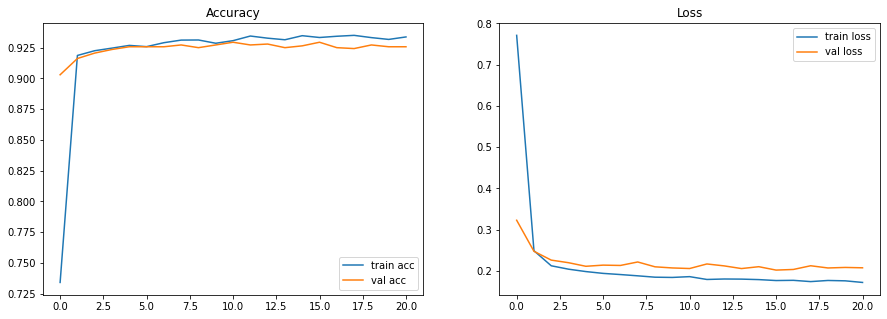

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"],label="train acc")
plt.plot(history["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"],label="train loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.show()

In [ ]:
loss ,accuracy = model.evaluate(test_ds)

43/43 [==============================] - 0s 8ms/step - loss: 0.1855 - accuracy: 0.9376


In [ ]:
print("test loss :",loss)
print("test accuracy :",accuracy)

test loss : 0.18552279472351074
test accuracy : 0.9375917911529541
